## Weather Blanket Big Data Project

### By Noa Lahan

---
# Contents
Introduction  
- Inspiration  

Getting Data  
- Research  
- Filtering and Cleaning  

Data Processing  

Discarded Prototypes  

Visualisation  

Final Outcome  

Links  
- GitHub Repository  
- Video Presentation   

Bibliography  

---


The project aims to process historical weather data to hopefully see a trend, specifically in terms of global warming as it is a topic that directly affects everyone ([WWF, 2016a]) and one that I am curious about.  
The data visualisation will be in the form of an online "weather blanket" which should allow for easy trend or anomaly spotting in the data.  
A weather blanket is a long-term project which is popular in crochet and knitting communities, in which the crafter adds one new row to the blanket every day over the course of a year, alternating the color of the current row based on that day's temperature. The end result produces a full length blanket with a variety of colors that creates a visual way to see the year's temperature changes ([Bollanos, 2024]). Some examples (taken from a quick [Pinterest search]):

![Example 1][Pin1] ![Example 2][Pin2] ![Example 3][Pin3] ![Example 4][Pin4]

Instead of a row representing a day and the blanket representing a year, the data collects 80 years worth of weather information, each row being a year, and each year will be seperated into its 365 days (366 on leap years).

---

[Bollanos, 2024]: https://www.handylittleme.com/temperature-blanket-patterns/
[Pin1]: img/pin1.png "Figure 1"
[Pin2]: img/pin2.png "Figure 2"
[Pin3]: img/pin3.png "Figure 3"
[Pin4]: img/pin4.png "Figure 4"
[Pinterest search]: https://www.pinterest.co.uk/search/pins/?q=weather%20blanket&rs=typed
[WWF, 2016a]: https://www.wwf.org.uk/climate-change-and-global-warming


The following two code blocks install and import all necessary libraries:


In [1]:
# ! pip install openmeteo-requests
# ! pip install requests-cache retry-requests numpy pandas

In [2]:
import openmeteo_requests
import requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt

import math

---

# Getting Data


Previously I chose a group of random countries from varying climates (see "Discarded Prototypes"). Instead I have done more thorough research to have a more concrete choice of countries.

I cross referenced a few relatively recent articles covering the countries that are most vulnerable to climate change ([Concern Worldwide, 2024];
[Iberdrola, 2021]; [The IRC, 2023])  
Some countries that appear in all three articles are: Afghanistan, Chad, Democratic Republic of Congo (DRC in this project for short), and Somalia.

Nasa's global temperature data page has a map that visualizes temperature differences from 1884 to 2022 ([NASA, 2024]). I went through the time frame that matches with that of this project's data (1940-2020) and took a few countries that have seen a dramatic temperature difference, either positive or negative.

![Poland][Nasa1] ![Canada][Nasa2] ![Egypt][Nasa3]

Another 4 countries were taken from these: From the first two figures, Poland and Canada (specifically northern) were saved for their noticebly warm temperature difference, and from figure 3 Egypt and Japan were saved for their notably cold temperature difference (Iceland was ignored as it already has been explored in the previous iteration of the project - see "Discarded Prototypes").

With a total of 8 countries, I chose to search the hottest and coolest temperatures recorded to round the total country count to 10.  
According to Saunders, the hottest recorded (air) temperature was in California's aptly named Death Valley, which also holds a few of the top hottest temperatures recorded in history ([Saunders, 2023]).  
On the other extreme, a team from NASA's scientific visualisation studio found central Antarctica to be the coldest place on earth ([Perkins et al., 2013]).

Brining the final country list to:

1. Afghanistan
2. Antarctica
3. Canada
4. Chad
5. DRC (Democratic Republic of Congo)
6. Egypt
7. Japan
8. Poland
9. Somalia
10. USA (California)

These were then googled for their individual coordinates which are required by the API used (Open Mateo) and saved into a dictionary as seen in the next code block. The getData() function in the code block that follows takes the response information from Open Mateos weather API (from the following code block, as labled), sorts it into Pandas data frames, and saves those into the countries dictionary that was previously mentioned.

[Concern Worldwide, 2024]: https://www.concern.net/news/countries-most-affected-by-climate-change
[Iberdrola, 2021]: https://www.iberdrola.com/sustainability/top-countries-most-affected-by-climate-change
[NASA, 2024]: https://climate.nasa.gov/vital-signs/global-temperature/?intent=121
[Nasa1]: img/fig1.png "Figure 1"
[Nasa2]: img/fig2.png "Figure 2"
[Nasa3]: img/fig3.png "Figure 3"
[Perkins et al., 2013]: https://svs.gsfc.nasa.gov/11415/
[Saunders, 2023]: https://www.sciencefocus.com/planet-earth/hottest-place-on-earth
[The IRC, 2023]: https://www.rescue.org/uk/article/10-countries-risk-climate-disaster


In [3]:
countries = {
    "lat" : [33.94, -82.86, 63.59, 15.45, -4.04, 26.82, 36.20, 51.92, 5.15, 36.53],
    "long" : [67.71, 135.0, -115.50, 18.73, 21.76, 30.80, 138.25, 19.15, 46.19, -116.93],
    "name" : ["Afghanistan", "Antarctica", "Canada", "Chad", "DRC", "Egypt", "Japan", "Poland", "Somalia", "USA"],
    "min" : [],
    "max" : [],
    "dif" : []
}

In [4]:
def getData(responses):
	''' 
    Parameters:
	openmateo response
	 
    Returns:
	array of daily data
    '''
	arr = []
	for i in range(len(countries["name"])):
		response = responses[i]
		print(f"Read {countries['name'][i]}, Coordinates {response.Latitude()}°N {response.Longitude()}°E")

		# Process daily data. The order of variables needs to be the same as requested.
		daily = response.Daily()
		daily_temp = daily.Variables(0).ValuesAsNumpy()

		data = {"date": pd.date_range(
			start = pd.to_datetime(daily.Time(), unit = "s", utc = False),
			end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = False),
			inclusive = "left"
		), "temp": daily_temp}

		df = pd.DataFrame(data = data)
		df.insert(1, "year", df['date'].dt.year)
		arr += [df]
	return arr

Get data from weather API open-mateo (note: initial code taken from open-mateo's documentation and changed as needed)


In [5]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Get data for 80 years (1940-2020)
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": countries.get("lat"),
	"longitude": countries.get("long"),
	"start_date": "1940-01-01",
	"end_date": "2020-12-31",
	"daily": "temperature_2m_min"
}
print("--- Daily Minimums ---")
responses = openmeteo.weather_api(url, params=params)
countries["min"] = getData(responses)

# repeat for max daily temperature
print("--- Daily Maximums ---")
params["daily"] = "temperature_2m_max"
responses = openmeteo.weather_api(url, params=params)
countries["max"] = getData(responses)

--- Daily Minimums ---
Read Afghanistan, Coordinates 33.91915512084961°N 67.66832733154297°E
Read Antarctica, Coordinates -82.84709930419922°N 135.0°E
Read Canada, Coordinates 63.585235595703125°N -115.57894897460938°E
Read Chad, Coordinates 15.430580139160156°N 18.760562896728516°E
Read DRC, Coordinates -4.042179107666016°N 21.784841537475586°E
Read Egypt, Coordinates 26.818979263305664°N 30.79734230041504°E
Read Japan, Coordinates 36.16871643066406°N 138.3896026611328°E
Read Poland, Coordinates 51.9156379699707°N 19.120880126953125°E
Read Somalia, Coordinates 5.166959762573242°N 46.22625732421875°E
Read USA, Coordinates 36.52021026611328°N -116.94117736816406°E
--- Daily Maximums ---
Read Afghanistan, Coordinates 33.91915512084961°N 67.66832733154297°E
Read Antarctica, Coordinates -82.84709930419922°N 135.0°E
Read Canada, Coordinates 63.585235595703125°N -115.57894897460938°E
Read Chad, Coordinates 15.430580139160156°N 18.760562896728516°E
Read DRC, Coordinates -4.042179107666016°N 2

---

# Data Processing


Global warming refers to the global average temperatrue's increase which causes a lot of changes to the climate. These are not only felt in terms of warmth, the World Wide Fund for Nature says this can also manifest in "more severe cold weather events" ([WWF, 2016b]).  
As such, I wanted to not only see both the maximum and minimum temperatures, but also the differences between them, to hopefully spot a pattern in increasingly polarized weather over the decades.

The next few blocks of code take the data collected in the previous section, find the differences between the daily maximums and minimums for all countries, and save all of the information into CSV files for each country. The CSV files will have the year, day, daily minimum, daily maximum, and daily difference for each day; the data is saved in this particular way with the rest of the data cleaning and visualisation process in mind.

[WWF, 2016b]: https://www.wwf.org.uk/updates/here-are-10-myths-about-climate-change


In [6]:
# find difference between max and min
for i in range(len(countries["name"])):
    min = countries["min"][i]
    max = countries["max"][i]
    diff = max.copy()
    dtemp = max["temp"] - min["temp"]
    diff["temp"] = dtemp
    countries["dif"] += [diff]

In [7]:
# create a days column
years = countries["min"][0]["year"]
days = []
index = 0
current = ""
for i in range(len(years)):
    if years[i] == current :
        index += 1
    else :
        current = years[i]
        index = 0
    days += [index]

Afghanistan


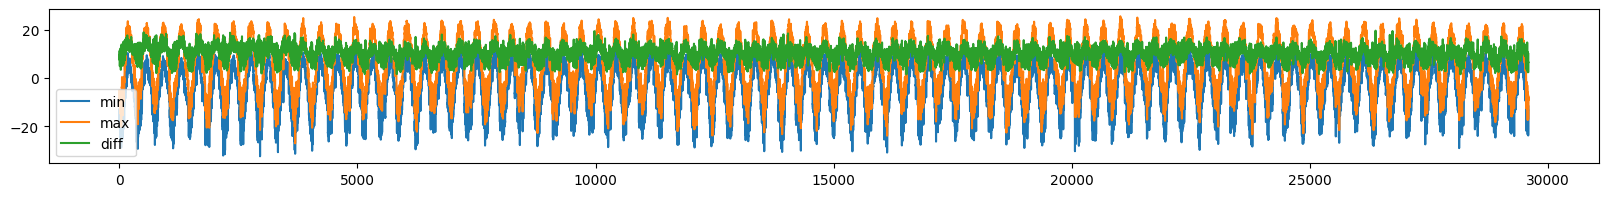

Antarctica


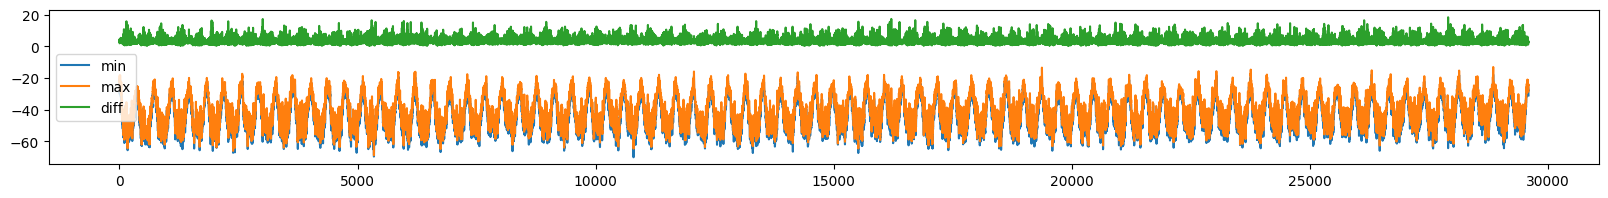

Canada


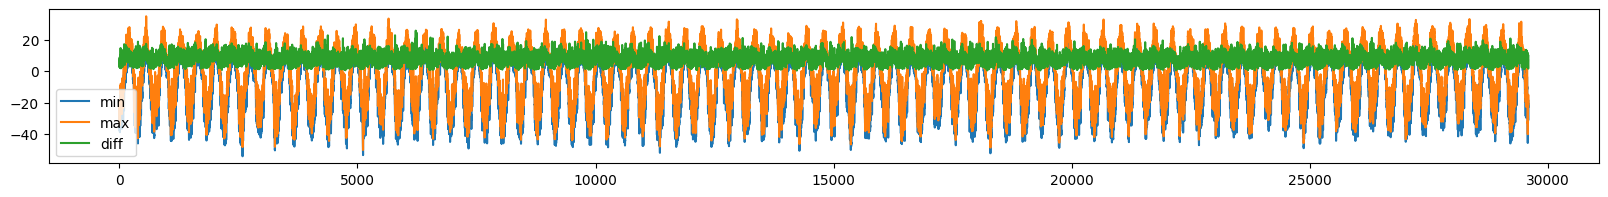

Chad


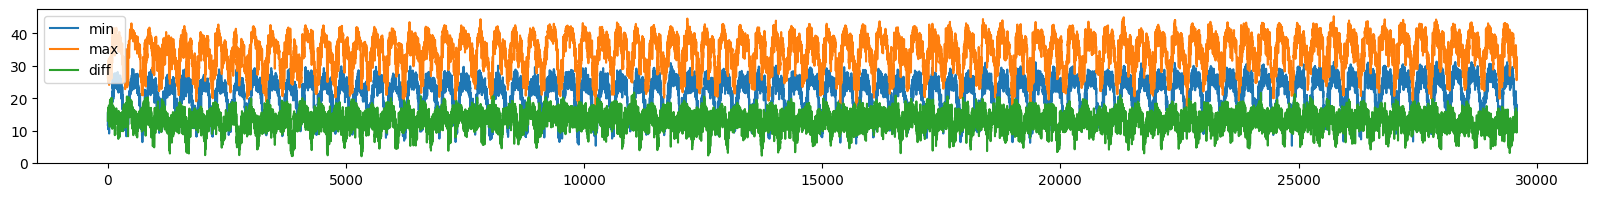

DRC


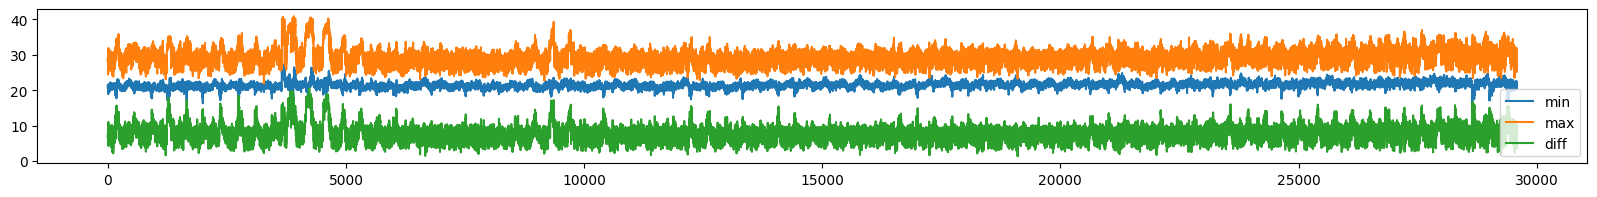

Egypt


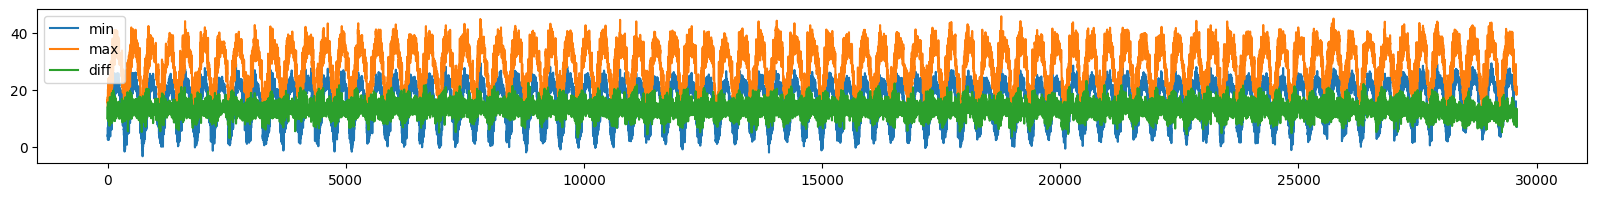

Japan


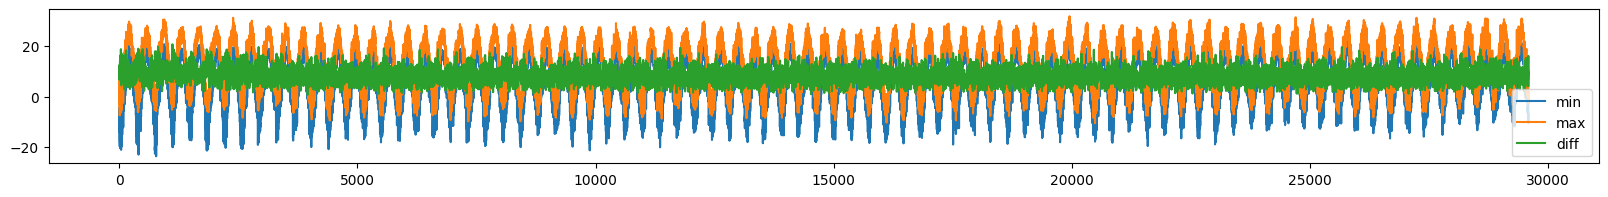

Poland


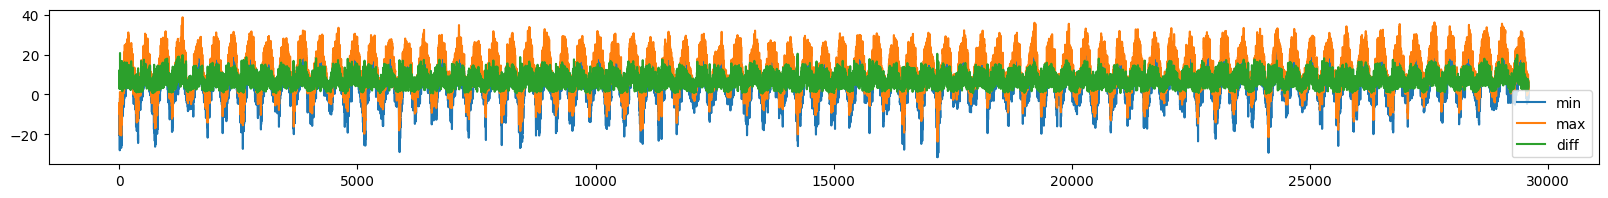

Somalia


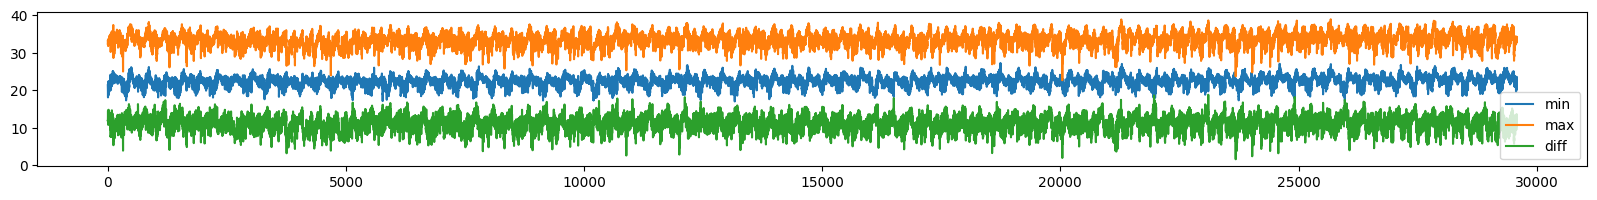

USA


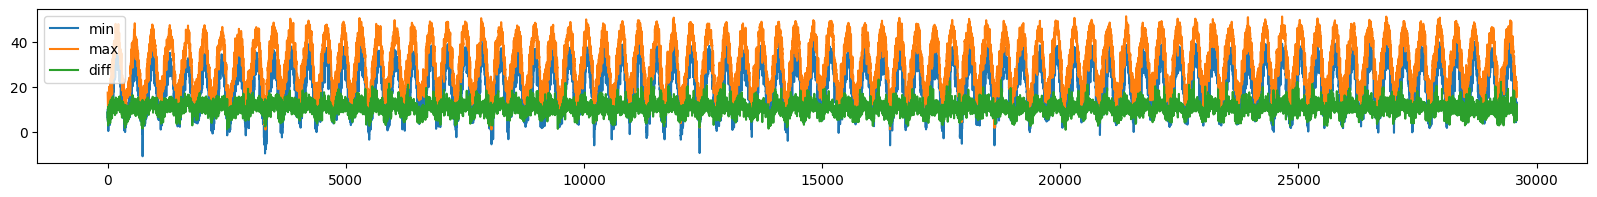

In [8]:
# save each country's data into a csv file for visualization
for i in range(len(countries["name"])):

   min = countries["min"][i]
   max = countries["max"][i]
   diff = countries["dif"][i]

   df = min.copy()
   df = df.rename(columns={'temp': 'min'})
   df["max"] = max["temp"]
   df["diff"] = diff["temp"]
   df["days"] = days

   # save to csv
   country = countries["name"][i]
   df.to_csv(country+'.csv', index=False)

   print(country)
   graph = df.copy()
   graph = graph.drop("date", axis='columns')
   graph = graph.drop("year", axis='columns')
   graph = graph.drop("days", axis='columns')
   # print(graph)
   graph.plot(figsize=(20, 2))
   plt.show()
   

Visualisation needs the max and min temperatures to know what the range is. Since we already know the max will be in the USA and the min will be in Antarctica (as those were selected for being the hottest and coldest points, respectively - see "Getting Data" section) I will get the coldest of Antarctica's daily minimums and the hottest of USA's daily maximums

Instead of using code to find the same range for the temperature differences, a quick look at the graph plots shows all differences graphs lay between 0 and 20 degree difference, so I will use that


In [9]:
print(countries["name"][1])
print(countries["min"][1].min())
print()
print(countries["name"][9])
print(countries["max"][9].max())

Antarctica
date    1940-01-01 00:00:00
year                   1940
temp             -70.131004
dtype: object

USA
date    2020-12-31 00:00:00
year                   2020
temp              51.181999
dtype: object


Also wanted to see how the yearly averages compare to all other countries. In the following block of code I take in turn each country, find the daily average, and then the yearly average. At the end I save all of the yearly averages into a pandas dataframe.


In [10]:
# all yearly averages
averages = {}
for i in range(len(countries["name"])):
    avg = []
    min = countries["min"][i]
    max = countries["max"][i]

    sum = 0
    count = 0
    current = 1940
    for j in range(len(min["temp"])):
          if(current != min["year"][j]):
               avg += [sum/count]
               sum = 0
               count = 0
               current = min["year"][j]
          else:
               sum += ((min["temp"][j] + max["temp"][j])/2)
               count += 1
               
    averages[countries["name"][i]] = avg

avg_df = pd.DataFrame(data = averages)

In [11]:
# min and max by country
print("Afghanistan")
print(avg_df["Afghanistan"].min())
print(avg_df["Afghanistan"].max())

print("Antarctica")
print(avg_df["Antarctica"].min())
print(avg_df["Antarctica"].max())

print("Canada")
print(avg_df["Canada"].min())
print(avg_df["Canada"].max())

print("Chad")
print(avg_df["Chad"].min())
print(avg_df["Chad"].max())

print("DRC")
print(avg_df["DRC"].min())
print(avg_df["DRC"].max())

print("Egypt")
print(avg_df["Egypt"].min())
print(avg_df["Egypt"].max())

print("Japan")
print(avg_df["Japan"].min())
print(avg_df["Japan"].max())

print("Poland")
print(avg_df["Poland"].min())
print(avg_df["Poland"].max())

print("Somalia")
print(avg_df["Somalia"].min())
print(avg_df["Somalia"].max())

print("USA")
print(avg_df["USA"].min())
print(avg_df["USA"].max())
avg_df

Afghanistan
-1.1263707263784095
2.568979297925348
Antarctica
-45.8296513400235
-39.88023294197334
Canada
-8.357510892080736
-2.519118040226973
Chad
26.043442003019564
29.204763519894946
DRC
24.494480992411518
28.744618405352583
Egypt
19.92661633818117
23.481970053452713
Japan
7.161116556108815
10.864538371562958
Poland
5.415511099692902
10.935519499683773
Somalia
27.150500549064887
28.725019706474555
USA
22.361362420595608
27.483854910829564


,Afghanistan,Antarctica,Canada,Chad,DRC,Egypt,Japan,Poland,Somalia,USA
0,-0.888951,-44.405238,-4.467393,27.168707,25.135011,20.731888,8.351833,5.415511,27.727311,23.797360
1,0.353162,-45.829651,-6.401618,27.412329,25.630992,21.269393,9.093843,6.138209,28.099612,22.361362
2,0.172256,-44.738374,-5.562264,27.008071,25.155168,21.159709,9.178390,6.466643,27.731274,23.366376
3,-0.684887,-43.761107,-5.203884,26.720571,25.326047,20.548788,8.938692,8.421382,27.672209,24.448107
4,0.229753,-44.627000,-4.307746,26.652650,25.520781,20.777438,9.373637,8.099877,27.925760,23.213520
...,...,...,...,...,...,...,...,...,...,...
75,1.065450,-42.241784,-3.947964,28.337593,26.585621,22.129360,9.802519,10.529357,28.273646,26.870805
76,2.568979,-41.864562,-3.676445,28.759253,26.926980,22.494815,10.174404,9.727904,28.543343,26.723781
77,0.502544,-41.347403,-4.060178,28.853129,26.681415,21.931170,9.899841,9.420822,28.493005,27.014423
78,0.882077,-39.880233,-5.109904,28.962401,26.141717,23.001706,10.864538,10.481467,27.989640,26.902954


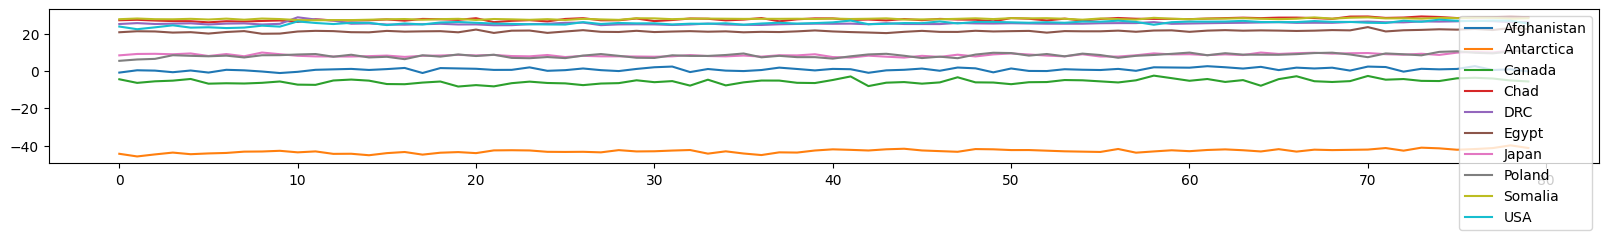

In [12]:
# plot and save information
avg_df.plot(figsize=(20, 2))
plt.show()

name = []
year = []
temp = []
for country in averages:
    value = averages[country]
    for i in range(len(value)):
        name += [country]
        year += [i]
        temp += [value[i]]

data = {
    "name" : name,
    "year" : year,
    "temp" : temp,
}
df = pd.DataFrame(data = data)
df.to_csv('All.csv', index=False)


In [13]:
# Global min and max
print(df["temp"].min())
print(df["temp"].max())
df


-45.8296513400235
29.204763519894946


,name,year,temp
0,Afghanistan,0,-0.888951
1,Afghanistan,1,0.353162
2,Afghanistan,2,0.172256
3,Afghanistan,3,-0.684887
4,Afghanistan,4,0.229753
...,...,...,...
795,USA,75,26.870805
796,USA,76,26.723781
797,USA,77,27.014423
798,USA,78,26.902954


---

# Discarded Prototype


As mentioned in the beginning of "Getting Data," there was a previous iteration of this project in which instead of researching which 10 countries would be the most relevant to the topic of climate change, I chose 10 random countries based on their climate (i.e. a few colder countries, a few hotter, a few in the middle). Additionally, I chose to find the monthly averages and print those, so there would be a more minimalistic visualisation (12 by 80 table instead of 365 by 80 table).

<img src="img/oldcode.png" width=700px/></br>
(The discarded code)

</br>
<img src="img/old1.png" width=500px/>
<img src="img/old2.png" width=500px/>
</br>
(The visualisation)

The visualisation was similar to the one in the updated project. Other than the smaller table (only 12 rows instead of 365, as mentioned), the outdated visualisation had a range input instead of the mode selection. This let the user select in what frame of reference they wanted to see a given country in. This meant that you could see countries in global reference:

<img src="img/old3.png" width=500px/>
<img src="img/old4.png" width=500px/>
</br>
(Argentina and Iceland global reference)

You could see countries in personal reference:

<img src="img/old5.png" width=500px/>
<img src="img/old6.png" width=500px/>
</br>
(Argentina in Argentina range and Iceland in Iceland range)

Or you could see countries in other countries' frame of reference:

<img src="img/old8.png" width=500px/>
<img src="img/old7.png" width=500px/>
</br>
(Argentina in Iceland range and Iceland in Argentina range)

There were a few mistakes that led to the current project. Firstly, the precarious country selection process was an issue, which was resolved by having more thorough research regarding global warming and choosing countries mentioned in those discussions (as outlined in "Getting Data"). Secondly, getting the monthly averages wipes out some anomalies in the weather; an especially hot day would be averaged out by all the typical days that surrounded it. This resulted in a visualisation that did not show much in terms of the topic that this project aims to focus on, by creating a visualisation in which a very consistent pattern can be seen and not much else. Lastly, the range function was not very benefitial. While interesting, seeing countries in other countries' frame of reference only showed how hot or cold they were in comparison to each other, which gives no information to the context in which this project was made. This was removed for the individual country visualisation in the updated project as I felt it would be more benefitial to have a consistent range so it is easier to understand the different countries' situations in comparison to one another. However a similar idea was used for the new all countries mode that the updated project has.


---

# Data Criticism


While there is a lot of information that was processed in this project, I have to note that this is not all that global warming is. Referring back to the World Wide Fund for Nature article referenced in "Data Processing," it notes that "climate change makes extreme weather more frequent and intense, including heatwaves, wildfires and floods" ([WWF, 2016b]). While temperature is a big aspect of global warming, it is important to understand that it is not the only in which it affects our daily lives. All of these extreme weather events will only become more frequent as climate change progresses and the situation gets worse ([European Environment Agency, 2024]). All of those events were completely ignored in this project and only the temperature data was collected. This is to say, that even if the final data visualisation result seems like only a mild change in weather, it does not mean that this is a minor inconvenience. Global warming is a dire issue that affects all and as such all should do their part to reverse it. Imperial College has made a fun informative webpage which has more detail about things we each can do about climate change, read more about it here: ([Imperial College London, 2018]).

[European Environment Agency, 2024]: https://www.eea.europa.eu/en/topics/in-depth/extreme-weather-floods-droughts-and-heatwaves
[Imperial College London, 2018]: https://www.imperial.ac.uk/stories/climate-action/
[WWF, 2016b]: https://www.wwf.org.uk/updates/here-are-10-myths-about-climate-change


---

# Visualisation


To make the visualisation I made a webpage with 3 drop down menus for all the different options.

<img src="img/ddmenus.png" height=500px/>
<img src="img/ddcode.png" height=500px/>
</br>
(Webpage and corresponding code)

The first two correspond to individual countries' data. The two work together; the country menu is used to select which country to show (which csv file to access) and the mode menu is used to select a mode (what data to use from the csv). The mode menu has three mode: max, min, and difference. The max and min correspond to the daily temperature data and show this in a color range going from blue to red, blue being the colder temperatures and red being the hotter ones. The difference mode is a singular color range (I chose purple after initially trying black as it made the knit pattern clearer, more on that later), and the darker the color, the bigger the difference between that day's high and low temperature. In either case, the result is a 366 by 80 grid (366 days, non-leap years leave a blank space at the bottom of the grid; 80 years) in which each square corresponds to a single day. To make the weather blanket aspect, a knit pattern was added on top of the page. The pattern has 12 rows, each corresponding to a month with the top row being January and the bottom December. The days also go from top to bottom, the 1st on the top and the 31st on the bottom, while the years go from left to right, from 1940 as the leftmost column and 2020 the rightmost. Meaning the grid goes in order from January 1st, 1940 in the top left corner, to December 31st, 2020 in the bottom right.  
The third drop down menu corresponds to the global data. That one always accesses the same csv file ("All.csv") and uses it to show all the countries' yearly averages in a 10 by 80 grid (10 countries; 80 years). The Different options on the range menu (all 10 countries and an additional "Global" option) determine the range in which the data will be shown. These are taken from the min and max temperature exploration in "Data Processing" and saved into a dictionary in the website's JavaScript file (see below). The range menu determines which min and max temperatures will be used to display the data, which allows the user to see more nuanced details in the way the average yearly temperature has changed over those 80 years. The global range mostly just shows that some countries are colder/hotter than others, but choosing a specific country's data range makes the range much smaller which makes it much easier to see changes from year to year. Here the blanket is slightly different. Instead of 12 knit rows there are only 10, each representing a country.

<img src="img/canada1.png" width=500px/>
<img src="img/canada2.png" width=500px/>
<img src="img/canada3.png" width=500px/>
</br>
(Canada's daily minimums, maximums, and differences, respectively)

</br>
</br>
<img src="img/all3.png" width=500px/>
<img src="img/antarctica4.png" width=500px/>
<img src="img/egypt4.png" width=500px/>
</br>
(Global yearly average's in global range, Antarctica's range, and Epypt's range, respectively)

</br>
</br>
<img src="img/dictionary.png" width=400px/>
</br>
(minimums and maximums dictionary)

The data was modeled using D3.js, a JavaScript library for data visualisation ([D3js.org, 2024]). Using it, I made two graphing functions, one for the countries, and one for global. D3 helped in creating the grid, designating values to each slot in it, and attributing a color to that value based on the ranges. The first graphing function requires that both the country and mode menus have been assigned a value before it starts graphing. Based on the country input the function knows what csv file to read, and based on the mode input the function changes the data accessed, range, and color scheme as needed. The other function only takes the range value as an input. It changes the knit pattern as to the 10 row one, displays the country names, and uses the range input to access the right min and max from the aforementioned dictionary.

<img src="img/jscode.png" width=500px/>
</br>
(The JS code; The code taken the inputs from the selected drop down menus and runs the corresponding graphing function accordingly)

[D3js.org, 2024]: https://d3js.org/


---

# Final Outcome

The following is a collection of screenshots from all of the visualisations and the csv files.


### Individual countries - CSV file, daily minimum, daily maximum, daily differences

Afghanistan:
</br>
<img src="img/afghanistan.png" height=300px/>
<img src="img/afghanistan1.png" height=300px/>
<img src="img/afghanistan2.png" height=300px/>
<img src="img/afghanistan3.png" height=300px/>
</br>

Antarctica:
</br>
<img src="img/antarctica.png" height=300px/>
<img src="img/antarctica1.png" height=300px/>
<img src="img/antarctica2.png" height=300px/>
<img src="img/antarctica3.png" height=300px/>
</br>

Canada:
</br>
<img src="img/canada.png" height=300px/>
<img src="img/canada1.png" height=300px/>
<img src="img/canada2.png" height=300px/>
<img src="img/canada3.png" height=300px/>
</br>

Chad:
</br>
<img src="img/chad.png" height=300px/>
<img src="img/chad1.png" height=300px/>
<img src="img/chad2.png" height=300px/>
<img src="img/chad3.png" height=300px/>
</br>

Democratic Republic of Congo:
</br>
<img src="img/drc.png" height=300px/>
<img src="img/drc1.png" height=300px/>
<img src="img/drc2.png" height=300px/>
<img src="img/drc3.png" height=300px/>
</br>

Egypt:
</br>
<img src="img/egypt.png" height=300px/>
<img src="img/egypt1.png" height=300px/>
<img src="img/egypt2.png" height=300px/>
<img src="img/egypt3.png" height=300px/>
</br>

Japan:
</br>
<img src="img/japan.png" height=300px/>
<img src="img/japan1.png" height=300px/>
<img src="img/japan2.png" height=300px/>
<img src="img/japan3.png" height=300px/>
</br>

Poland:
</br>
<img src="img/poland.png" height=300px/>
<img src="img/poland1.png" height=300px/>
<img src="img/poland2.png" height=300px/>
<img src="img/poland3.png" height=300px/>
</br>

Somalia:
</br>
<img src="img/somalia.png" height=300px/>
<img src="img/somalia1.png" height=300px/>
<img src="img/somalia2.png" height=300px/>
<img src="img/somalia3.png" height=300px/>
</br>

California, USA:
</br>
<img src="img/usa.png" height=300px/>
<img src="img/usa1.png" height=300px/>
<img src="img/usa2.png" height=300px/>
<img src="img/usa3.png" height=300px/>
</br>

### All countries

CSV files:
</br>
<img src="img/all1.png" height=300px/>
<img src="img/all4.png" height=300px/>
</br>
(all in a row, split by country)

Global range:
</br>
<img src="img/all3.png" height=300px/>
</br>

Afghanistan's range:
</br>
<img src="img/afghanistan4.png" height=300px/>
</br>

Antarctica's range:
</br>
<img src="img/antarctica4.png" height=300px/>
</br>

Canada's range:
</br>
<img src="img/canada4.png" height=300px/>
</br>

Chad's range:
</br>
<img src="img/chad4.png" height=300px/>
</br>

Democratic Republic of Congo's range:
</br>
<img src="img/drc4.png" height=300px/>
</br>

Egypt's range:
</br>
<img src="img/egypt4.png" height=300px/>
</br>

Japan's range:
</br>
<img src="img/japan4.png" height=300px/>
</br>

Poland's range:
</br>
<img src="img/poland4.png" height=300px/>
</br>

Somalia's range:
</br>
<img src="img/somalia4.png" height=300px/>
</br>

California, USA's range:
</br>
<img src="img/usa4.png" height=300px/>
</br>


---

# Links


Git hub: https://git.arts.ac.uk/23043904/bigdata/tree/main/project  
Video walkthrough: https://youtu.be/_AtRaT_nCmU


---
# Bibliography

‌Bollanos, L. (2024). 20 Temperature Blanket Patterns. [online] Handy Little Me. Available at: https://www.handylittleme.com/temperature-blanket-patterns/ [Accessed 7 Jun. 2024].

‌Concern Worldwide. (2024). The 10 countries most affected by climate change in 2024. [online] Available at: https://www.concern.net/news/countries-most-affected-by-climate-change [Accessed 7 Jun. 2024].

D3js.org. (2024). D3 by Observable | The JavaScript library for bespoke data visualization. [online] Available at: https://d3js.org/ [Accessed 7 Jun. 2024].

‌European Environment Agency (2024). Extreme weather: floods, droughts and heatwaves. [online] Europa.eu. Available at: https://www.eea.europa.eu/en/topics/in-depth/extreme-weather-floods-droughts-and-heatwaves [Accessed 7 Jun. 2024].

‌Iberdrola (2021). COUNTRIES MOST AFFECTED BY CLIMATE CHANGE. [online] Iberdrola. Available at: https://www.iberdrola.com/sustainability/top-countries-most-affected-by-climate-change [Accessed 7 Jun. 2024].

‌Imperial College London (2018). 9 things you can do about climate change. [online] Imperial.ac.uk. Available at: https://www.imperial.ac.uk/stories/climate-action/ [Accessed 7 Jun. 2024].

‌NASA (2024). Global Surface Temperature | NASA Global Climate Change. [online] Climate Change: Vital Signs of the Planet. Available at: https://climate.nasa.gov/vital-signs/global-temperature/?intent=121 [Accessed 7 Jun. 2024].

‌Perkins, L., Scambos, T., Irons, J.R., Haran, T., Campbell, G., Pope, A. and Ramsayer, K. (2013). The Coldest Place On Earth. [online] NASA Scientific Visualization Studio. Available at: https://svs.gsfc.nasa.gov/11415/ [Accessed 7 Jun. 2024].

Pinterest. (2024). Weather Blanket Search. [online] Available at: https://www.pinterest.co.uk/search/pins/?q=weather%20blanket&rs=typed [Accessed 7 Jun. 2024].

‌Saunders, T. (2023). Top 10 hottest places on Earth, ranked. [online] Sciencefocus.com. Available at: https://www.sciencefocus.com/planet-earth/hottest-place-on-earth [Accessed 7 Jun. 2024].

‌The IRC. (2023). 10 countries at risk of climate disaster. [online] Available at: https://www.rescue.org/uk/article/10-countries-risk-climate-disaster [Accessed 7 Jun. 2024].

‌WWF. (2016a). What are climate change and global warming? [online] Available at: https://www.wwf.org.uk/climate-change-and-global-warming [Accessed 7 Jun. 2024].

‌WWF. (2016b). Here are 10 myths about climate change. [online] Available at: https://www.wwf.org.uk/updates/here-are-10-myths-about-climate-change [Accessed 7 Jun. 2024].

‌